# Source Extraction and Photometry

Taken from [SEP Tutorial)](https://sep.readthedocs.io/en/v1.0.x/tutorial.html#Background-subtraction)

In [1]:
import numpy as np
import sep
import cv2
import csv
import os
import re
import math
from math import sin, cos, tan, sqrt, acos
import matplotlib.pyplot as plt
from matplotlib import rcParams
import subprocess
import random
from IPython.display import Markdown

%matplotlib inline

rcParams['figure.figsize'] = [15., 15.]

In [2]:
image = np.flip(cv2.imread('../tests/image20200103013529.png', -1),0)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype('single')
#apply the mask and remove the outer 10% of the aperture
mask = np.zeros(gray.shape)
cv2.circle(mask, tuple([z // 2 for z in gray.shape]), int(0.9*(gray.shape[0] / 2)), 1., -1)
_ = np.multiply(gray, mask, out=gray)

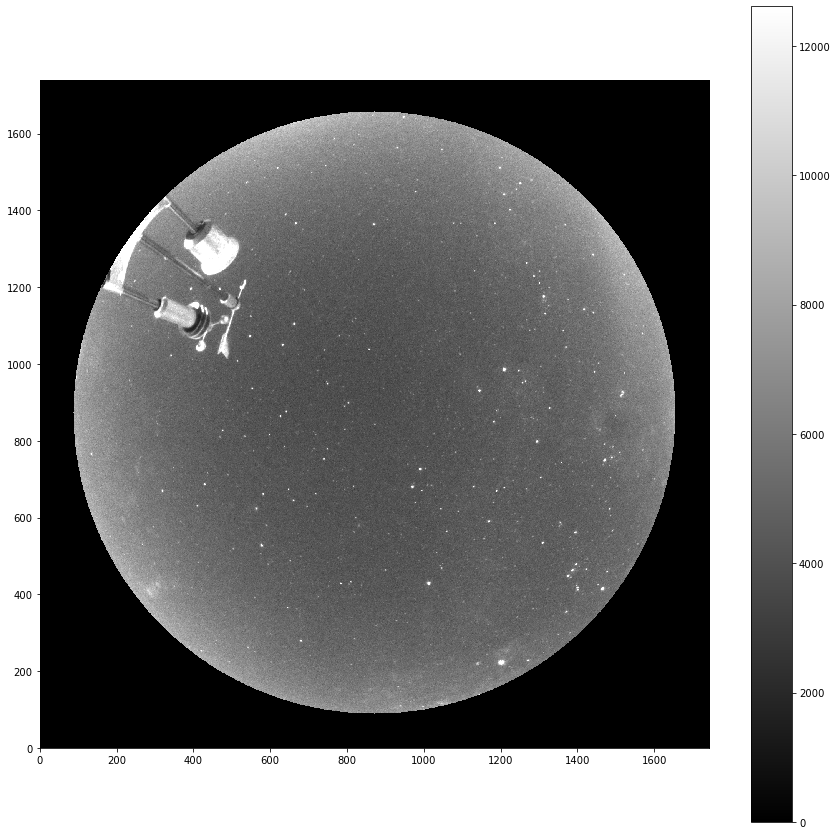

In [3]:
# show the image
m, s = np.mean(gray), 3*np.std(gray)
plt.imshow(gray, interpolation='nearest', cmap='gray', vmin=max(m-s,0), vmax=m+s, origin='lower')
plt.colorbar();

## Remove Weather Station

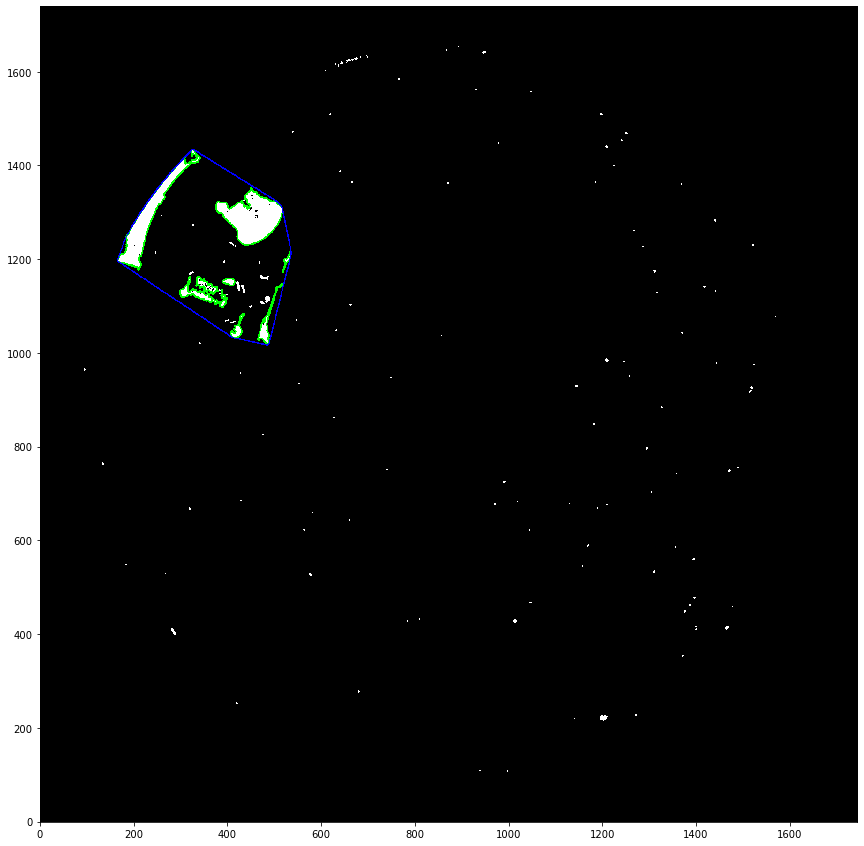

In [4]:
bin_threshold = 10000
open_kernel = 3
min_area = 150
# Do first thresholding of image on 16bit gray values
_,fgray = cv2.threshold(gray,bin_threshold,65535,cv2.THRESH_BINARY)
# Then remove small features (determined by the size of the ellipse kernel) with morphology open
fgray = cv2.morphologyEx((fgray/256).astype('uint8'), cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(open_kernel,open_kernel)))
# Then extract contours of remaining structures
cnts, _ = cv2.findContours(fgray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Filter found contours by dropping the ones with area below area threshold
cnts_filtered = []
for curve in cnts:
    area = cv2.contourArea(curve)
    if area > min_area:
        cnts_filtered.append(curve)
        
# Merge all contours and get convex-hull of them
cnts_concat = np.concatenate( cnts_filtered, axis=0 )
hull = [cv2.convexHull(cnts_concat)]

# Convert grayscale image back to 3 channels to be able to show contours in color
img = cv2.cvtColor(fgray, cv2.COLOR_GRAY2BGR)

# Draw contours above area threshold in input image
img = cv2.drawContours(img, cnts_filtered, -1, (0, 255, 0), 2)
# Draw convex hull of remaining contours in input image
img = cv2.drawContours(img, hull, -1, (0, 0, 255), 2)

plt.figure(figsize = (15,15))
plt.imshow(img, cmap='gray', origin='lower')

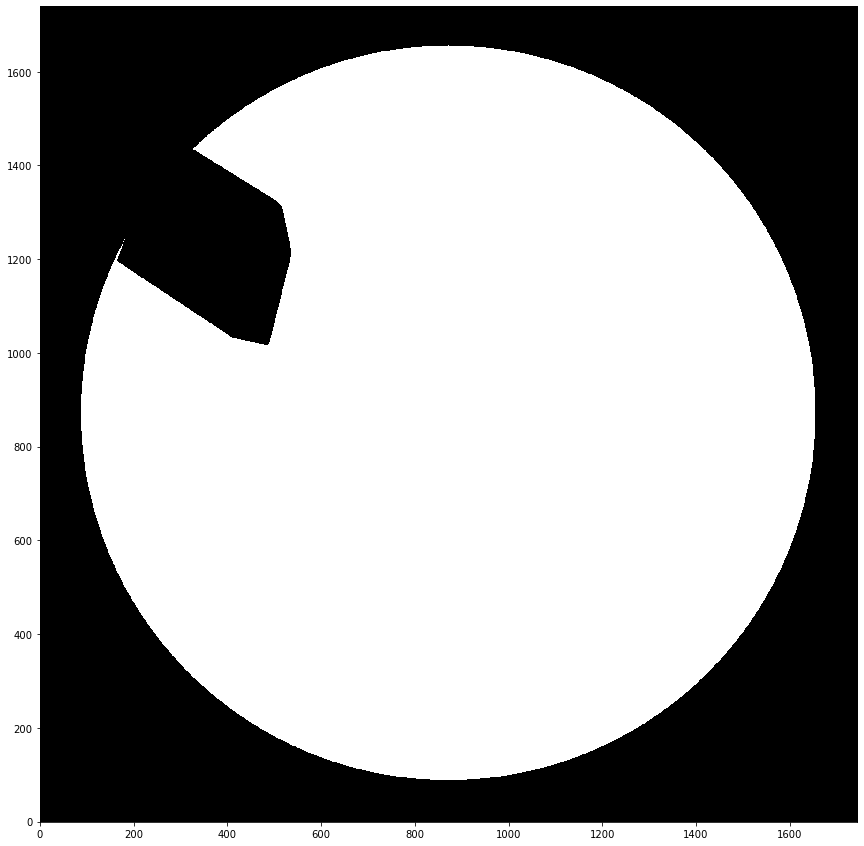

In [5]:
# Update the mask accordingly
mask = cv2.drawContours(mask, hull, -1, 0, -1)
plt.figure(figsize = (15,15))
plt.imshow(mask, cmap='gray', origin='lower')

## Background subtraction

In [6]:
data = gray.copy(order='C')
data.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [7]:
# measure a spatially varying background on the image
bkg = sep.Background(data, bw=8, bh=8)
#mask = np.zeros(data.shape)
#cv2.circle(mask, tuple([z // 2 for z in data.shape]), data.shape[0] // 2, 1., -1)
#bkg = sep.Background(data, mask=mask, bw=32, bh=32, fw=3, fh=3)

In [8]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

4330.99755859375
316.5620422363281


In [9]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()

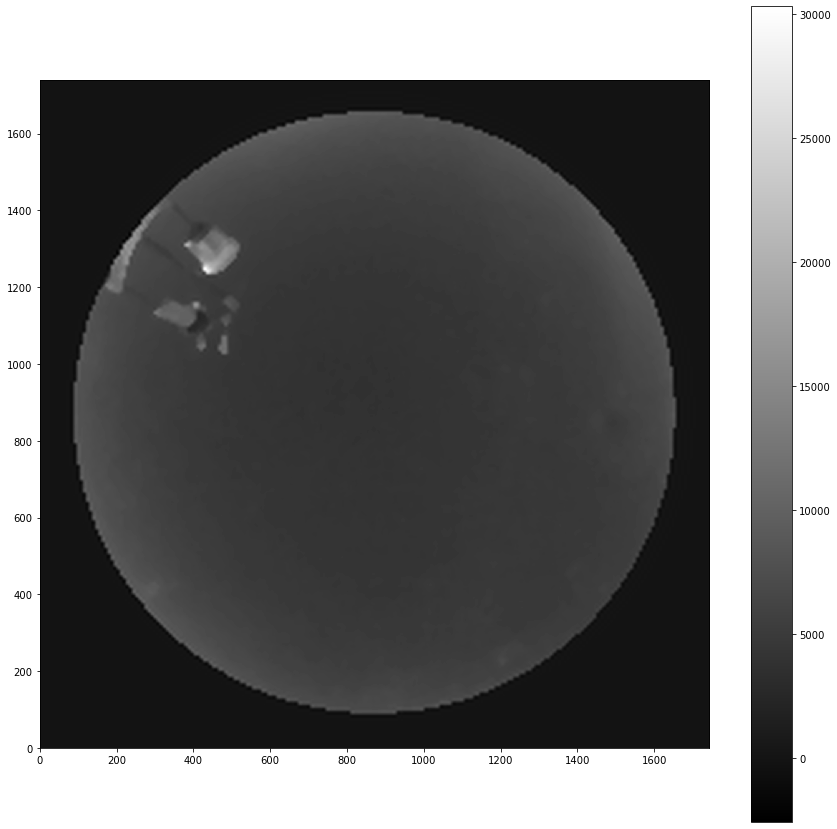

In [10]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [11]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

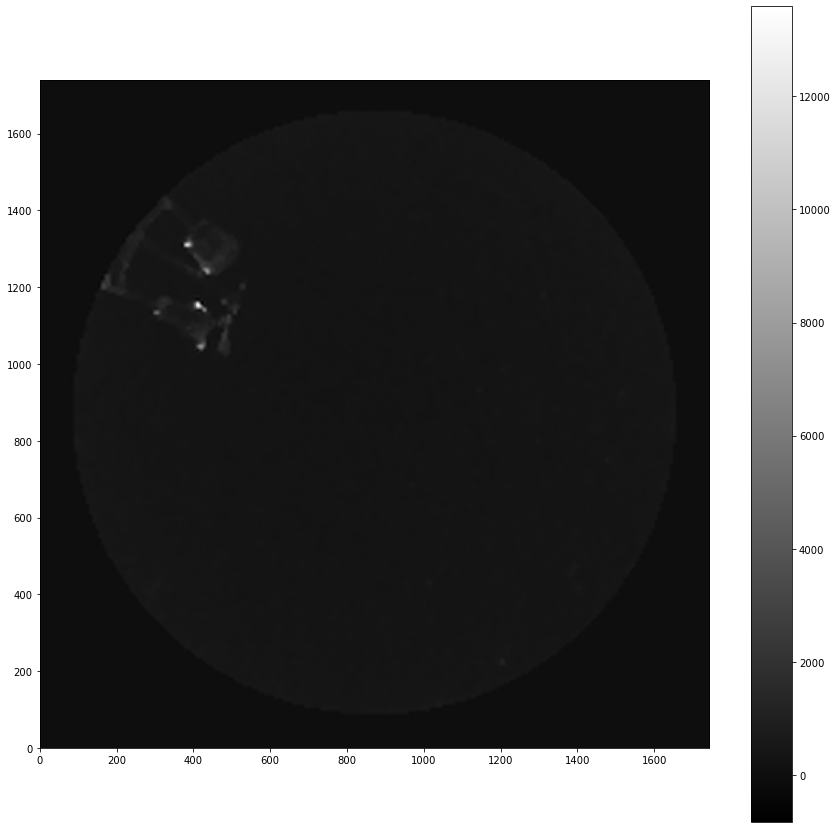

In [12]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [13]:
# subtract the background and apply mask
kernel = np.ones((10,10),np.uint8)
eroded_mask = cv2.erode(mask,kernel,iterations = 1)
data_sub = (data - bkg)*eroded_mask

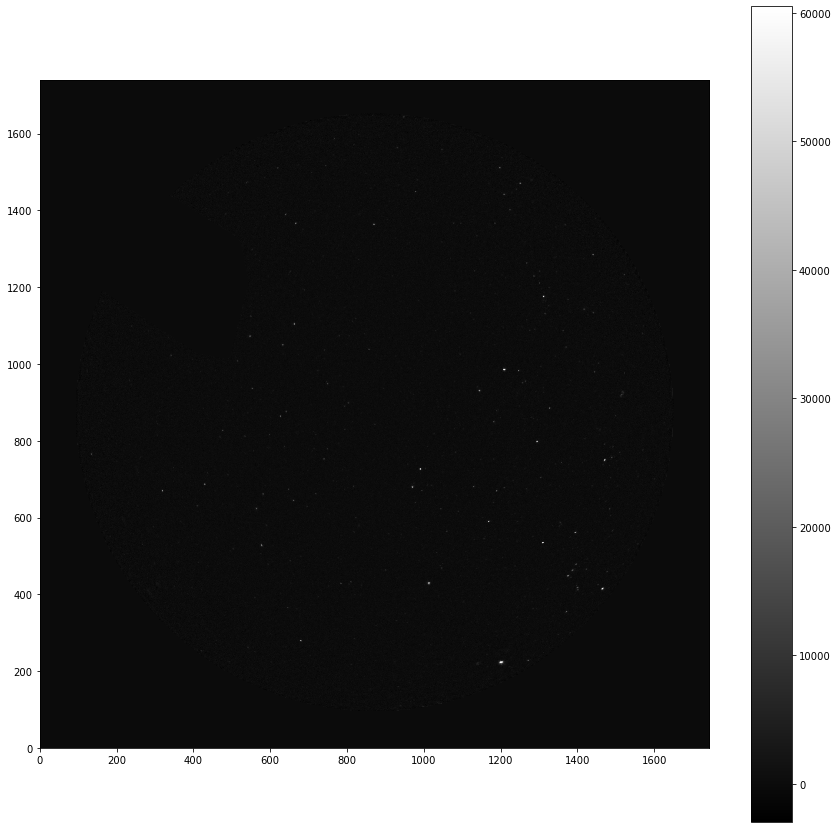

In [14]:
# show the background noise
plt.imshow(data_sub, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

## Source Extraction and Photometry

In [15]:
objects = sep.extract(data_sub, 10.0, err=bkg.globalrms)
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [16]:
# how many objects were detected
len(objects)

149

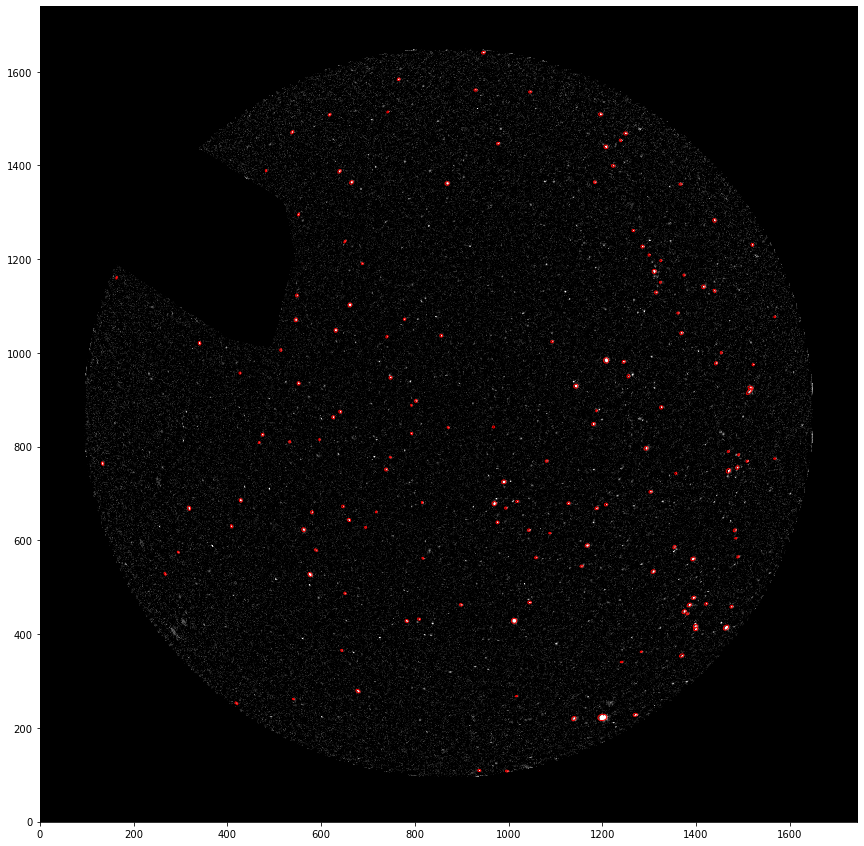

In [17]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), 10*np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=max(m-s,0), vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

## Estimation of equatorial coordinates of camera zenith

In [18]:
import ephem, math

In [19]:
position = ephem.Observer()
position.pressure = 0
position.lon, position.lat = str(15.398836), str(46.973066)
position.elevation = 350
# Time of image was right after exposure, so half of the exposure time 20/2 = 10 s has been subtracted
# Time is in UTC so one hour has to be subtracted from local CET time
position.date = '2020/01/03 00:35:19'

In [20]:
print(position.sidereal_time())

8:25:21.85


## Get equatorial coordinates of zenith

In [21]:
az = 0
el = math.pi / 2
ra, de = position.radec_of(az, el)
print('ra_central = %f, de_central = %f' % (ra * 180 / math.pi / 15, de * 180 / math.pi))

ra_central = 8.399124, de_central = 47.040162


## Write configuration file for star-charter and generate constellation overlay

In [22]:
%%writefile allskycam.sch
# Configuration file to produce an alt/az projection with the approximate zenit position of camera

# Default chart settings
DEFAULTS
plot_equator=0
plot_galactic_plane=0
plot_ecliptic=0
copyright=''
copyright_gap=0
copyright_gap_2=0
great_circle_key=0
magnitude_key=0
mag_min=5.0
ra_central=9.403361
dec_central=47.061743
position_angle=0
width=43.5
constellation_boundaries=0
constellation_sticks=1
ra_dec_lines=0
coords=ra_dec
star_names=1
star_label_mag_min=1.5

# Produce a copy of this chart using alt/az projection of the whole sky, with specified central point at the zenith
CHART
output_filename=allskycam.png
projection=alt_az
messier_col=0,0.8,0.8
galaxy_col=0,0,0
galaxy_col0=0,0,0
star_col=0.95,0.95,0.95
grid_col=0.3,0.3,0.3
equator_col=0.65,0,0.65
galactic_plane_col=0,0.8,0.25
ecliptic_col=0.8,0.65,0
constellation_label_col=0.4,0.4,0.4

Overwriting allskycam.sch


In [23]:
subprocess.check_output(['../../star-charter/bin/starchart.bin','allskycam.sch'])

b''

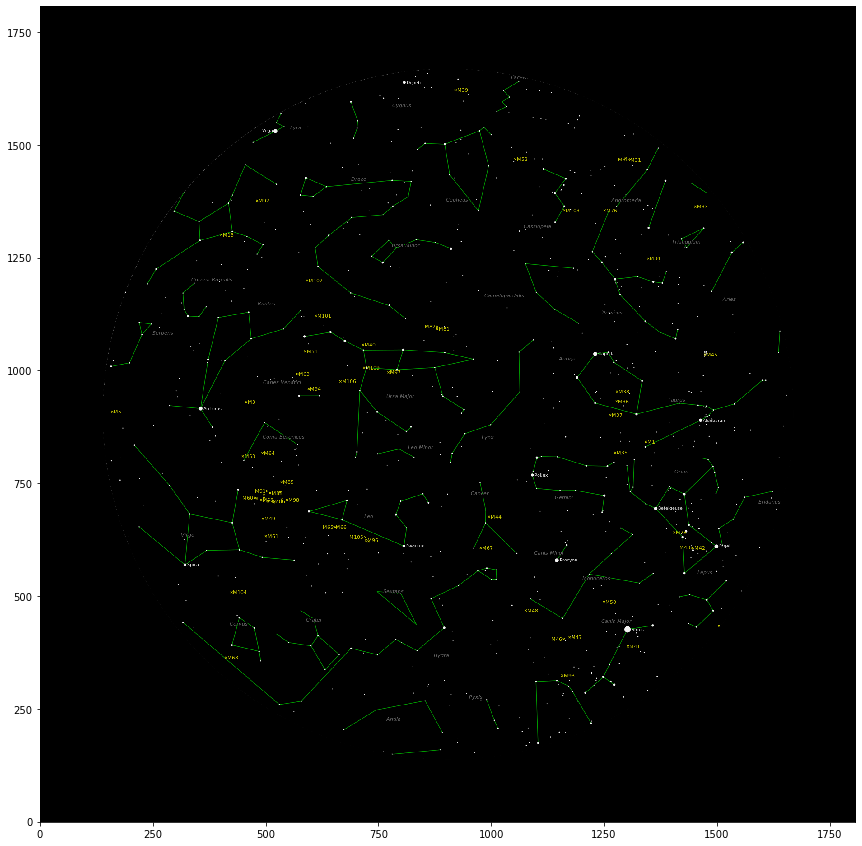

In [24]:
chart = np.flip(cv2.imread('allskycam.png'),0)
plt.imshow(chart, interpolation='nearest', origin='lower')


* thresh (float) Threshold at object location.
* npix (int) Number of pixels belonging to the object.
* tnpix (int) Number of pixels above threshold (unconvolved data).
* xmin, xmax (int) Minimum, maximum x coordinates of pixels.
* ymin, ymax (int) Minimum, maximum y coordinates of pixels.
* x, y (float) object barycenter (first moments).
* x2, y2, xy (float) Second moments.
* errx2, erry2, errxy (float) Second moment errors. Note that these will be zero if error is not given.
* a, b, theta (float) Ellipse parameters, scaled as described by Section 8.4.2 in “The Source Extractor Guide” or Section 10.1.5-6 of v2.13 of SExtractor’s User Manual.
* cxx, cyy, cxy (float) Alternative ellipse parameters.
* cflux (float) Sum of member pixels in convolved data.
* flux (float) Sum of member pixels in unconvolved data.
* cpeak (float) Peak value in convolved data.
* peak (float) Peak value in unconvolved data.
* xcpeak, ycpeak (int) Coordinate of convolved peak pixel.
* xpeak, ypeak (int) Coordinate of unconvolved peak pixel.
* flag (int) Extraction flags.

In [25]:
#Collect all data of identified objects needed for comparison (x,y position and magnitude of object) into one list of lists.
#We calculate a relative magnitude of the stars by relating to the maximum flux. The magnitude distribution should be
#similiar but just shifted compared to the Yale catalog (we check this later)
z2polar = lambda z: ( np.abs(z), np.angle(z) )
sources=list(map(list, zip(*[list(objects['x']),list(objects['y']),list(-2.5*np.log10(flux/np.amax(flux)))])))
sources.sort(key=lambda x: x[2])

In [26]:
#Export Barycenter position (polar) and Peak value into CSV file named sources.csv
import csv

with open("sources.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(sources)

## Import Yale Bright Star Catalog for ra,dec positions of bright stars

In [27]:
def fetch_yale_bright_star_list(catalog_dir="data/Yale_Bright_Star_Catalog"):
    """
    Read the Yale Bright Star Catalogue from disk, and return it as a dictionary of stars.
    Basis of routine was: https://github.com/dcf21/planisphere/blob/master/bright_stars_process.py
    :return:
        Dictionary with hd_number as key
    """

    # Build a dictionary of stars, indexed by HD number
    stars = {}

    # Convert three-letter abbreviations of Greek letters into UTF-8
    greek_alphabet = {'Alp': '\u03b1', 'Bet': '\u03b2', 'Gam': '\u03b3', 'Del': '\u03b4', 'Eps': '\u03b5',
                      'Zet': '\u03b6', 'Eta': '\u03b7', 'The': '\u03b8', 'Iot': '\u03b9', 'Kap': '\u03ba',
                      'Lam': '\u03bb', 'Mu': '\u03bc', 'Nu': '\u03bd', 'Xi': '\u03be', 'Omi': '\u03bf',
                      'Pi': '\u03c0', 'Rho': '\u03c1', 'Sig': '\u03c3', 'Tau': '\u03c4', 'Ups': '\u03c5',
                      'Phi': '\u03c6', 'Chi': '\u03c7', 'Psi': '\u03c8', 'Ome': '\u03c9'}

    # Superscript numbers which we may place after Greek letters to form the Flamsteed designations of stars
    star_suffices = {'1': '\u00B9', '2': '\u00B2', '3': '\u00B3'}

    # Look up the common names of bright stars from the notes section of the catalog
    star_names = []
    notes_file = os.path.join(catalog_dir, "notes")
    for line in open(notes_file, "rt"):
        if re.match("^\s+\d+\s1N\:\s+([a-zA-Z\s\,\'\"\(\)]+(\;|\.))+", line) is not None:
            res = re.split(" 1N:\s+|; |\.|,", line.strip())
            star_names.append([int(res[0]),
                               re.sub('Called | in Becvar| in most catalogues|\"|Usually called | \(rarely used\)',
                                      '', res[1]).lower().title()])
    star_names = dict(star_names)
    non_star_names = [182, 575, 662, 958, 2227, 2462, 2548, 2944, 2954, 2970, 3080, 3084, 3113, 3185, 3447, 3464, 3659, 3669, 3738, 5573, 5764, 6957, 7955, 8066, 8213, 8371, 8406]
    for k in non_star_names:
        star_names.pop(k, None)

    catalog_file = os.path.join(catalog_dir, "catalog")

    # Loop through the Yale Bright Star Catalog, line by line
    bs_num = 0
    for line in open(catalog_file, "rt"):
        # Ignore blank lines and comment lines
        if (len(line) < 100) or (line[0] == '#'):
            continue

        # Counter used too calculated the bright star number -- i.e. the HR number -- of each star
        bs_num += 1
        try:
            # Read the Henry Draper (i.e. HD) number for this star
            hd = int(line[25:31])

            # Read the right ascension of this star (J2000)
            ra_hrs = float(line[75:77])
            ra_min = float(line[77:79])
            ra_sec = float(line[79:83])

            # Read the declination of this star (J2000)
            dec_neg = (line[83] == '-')
            dec_deg = float(line[84:86])
            dec_min = float(line[86:88])
            dec_sec = float(line[88:90])

            # Read the V magnitude of this star
            mag = float(line[102:107])
        except ValueError:
            continue

        # Look up the Bayer number of this star, if one exists
        star_num = -1
        try:
            star_num = int(line[4:7])
        except ValueError:
            pass

        # Render a unicode string containing the name, Flamsteed designation, and Bayer designation for this star
        name_bayer = name_bayer_full = name_english = name_flamsteed_full = "-"

        # Look up the Greek letter (Flamsteed designation) of this star
        greek = line[7:10].strip()

        # Look up the abbreviation of the constellation this star is in
        const = line[11:14].strip()

        # Some stars have a suffix after the Flamsteed designation, e.g. alpha-1, alpha-2, etc.
        greek_letter_suffix = line[10]
        if greek in greek_alphabet:
            name_bayer = greek_alphabet[greek]
            if greek_letter_suffix in star_suffices:
                name_bayer += star_suffices[greek_letter_suffix]
            name_bayer_full = '{}-{}'.format(name_bayer, const)
        if star_num > 0:
            name_flamsteed_full = '{}-{}'.format(star_num, const)

        # See if this is a star with a name
        if bs_num in star_names:
            name_english = star_names.get(bs_num, "-")

        # Turn RA and Dec from sexagesimal units into decimal
        ra = (ra_hrs + ra_min / 60 + ra_sec / 3600) / 24 * 360
        dec = (dec_deg + dec_min / 60 + dec_sec / 3600)
        if dec_neg:
            dec = -dec

        # Build a dictionary is stars, indexed by HD number
        stars[hd] = [ra, dec, mag, name_bayer, name_bayer_full, name_english, name_flamsteed_full, hd]

    hd_numbers = list(stars.keys())
    hd_numbers.sort()

    return {
        'stars': stars,
        'hd_numbers': hd_numbers
    }

In [28]:
yale_catalog = fetch_yale_bright_star_list(catalog_dir="../data/Yale_Bright_Star_Catalog")

In [29]:
#Convert equatorial coordinates into horizontal ones and just take stars above horizon
star = ephem.FixedBody()
starpos = []
star._epoch = '1900'
for hd in yale_catalog['hd_numbers']:
    star._ra, star._dec = yale_catalog['stars'][hd][0] * math.pi / 180, yale_catalog['stars'][hd][1] * math.pi / 180
    star.compute(position)
    if star.alt > 0:
        starpos.append([star.alt, star.az, yale_catalog['stars'][hd][2], yale_catalog['stars'][hd][-1]])
#Sort after magnitude
starpos.sort(key=lambda x: x[2])

In [30]:
print(len(yale_catalog['stars']),len(starpos))

9096 4588


In [31]:
#Export yale_catalog data into CSV file named sources.csv

catalog=[]
for hd in yale_catalog['hd_numbers']:
    catalog.append(yale_catalog['stars'][hd])
with open("yale.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(catalog)

UnicodeEncodeError: 'charmap' codec can't encode character '\u03b1' in position 42: character maps to <undefined>

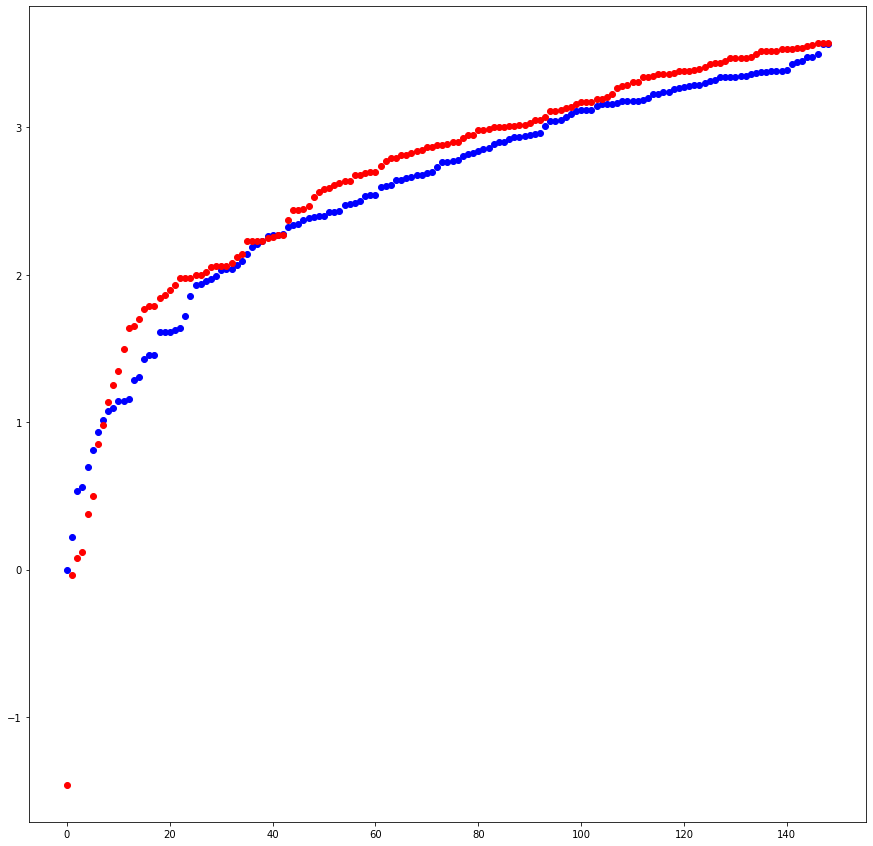

In [32]:
plt.plot(range(len(sources)), [row[2] for row in sources], 'bo',range(len(sources)),[row[2] for row in starpos[:len(sources)]], 'ro')
#plt.axis([0, 6, 0, 20])
plt.show()

## Coordinate System of camera transfer into equatorial system

C:\Users\Rainer\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


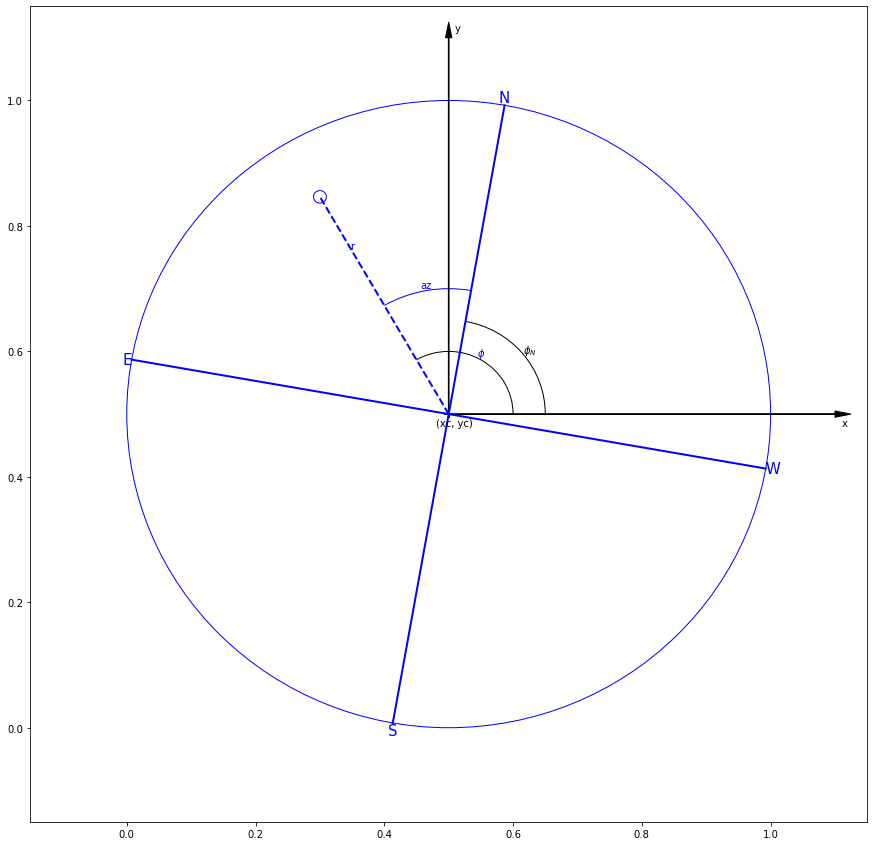

In [33]:
from matplotlib import patches
from matplotlib import lines

phi_n = 80*math.pi/180
phi_star = 120*math.pi/180
polar2z = lambda r, phi, x0, y0: [r * np.cos(phi)+x0, r * np.sin(phi)+y0]

fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

ax.set_xlim([-0.15, 1.15])
ax.set_ylim([-0.15, 1.15])
circle = patches.Circle((0.5, 0.5), radius=0.5, color='blue', fill=False)
ax.add_patch(circle)
line1 = lines.Line2D([0.495, 0.505], [0.50, 0.50], color='k', linestyle='-', linewidth=2)
ax.add_artist(line1)
line2 = lines.Line2D([0.50, 0.50], [0.495, 0.505], color='k', linestyle='-', linewidth=2)
ax.add_artist(line2)
ax.text(0.48, 0.48, '(xc, yc)', fontsize=10)
ax.arrow(0.5, 0.5, 0.6, 0, head_width=0.01, head_length=0.025, fc='k', ec='k')
ax.text(1.11, 0.48, 'x', fontsize=10)
ax.arrow(0.5, 0.5, 0, 0.6, head_width=0.01, head_length=0.025, fc='k', ec='k')
ax.text(0.51, 1.11, 'y', fontsize=10)
p = [polar2z(0.5, phi_n, 0.5, 0.5), polar2z(0.5, phi_n+math.pi, 0.5, 0.5)]
line3 = lines.Line2D([p[0][0], p[1][0]], [p[0][1], p[1][1]], color='b', linestyle='-', linewidth=2)
ax.add_artist(line3)
ax.text(p[0][0], p[0][1], 'N', fontsize=15, ha='center', va='bottom', color='b')
ax.text(p[1][0], p[1][1], 'S', fontsize=15, ha='center', va='top', color='b')

p = [polar2z(0.5, phi_n+math.pi/2, 0.5, 0.5), polar2z(0.5, phi_n+3*math.pi/2, 0.5, 0.5)]
line4 = lines.Line2D([p[0][0], p[1][0]], [p[0][1], p[1][1]], color='b', linestyle='-', linewidth=2)
ax.add_artist(line4)
ax.text(p[0][0], p[0][1], 'E', fontsize=15, ha='right', va='center', color='b')
ax.text(p[1][0], p[1][1], 'W', fontsize=15, ha='left', va='center', color='b')

arc1 = patches.Arc((0.5,0.5),0.3,0.3,0,0,phi_n*180/math.pi)
ax.add_patch(arc1)
p = polar2z(0.15,phi_n/2,0.5,0.5)
ax.text(p[0],p[1],'$\phi_N$', fontsize=10)

p = polar2z(0.4, phi_star, 0.5, 0.5)

circle2 = patches.Circle((p[0], p[1]), radius=0.01, color='blue', fill=False)
ax.add_patch(circle2)
line5 = lines.Line2D([0.5, p[0]], [0.5, p[1]], color='b', linestyle='--', linewidth=2)
ax.add_artist(line5)
p = polar2z(0.3, phi_star, 0.5, 0.5)
ax.text(p[0],p[1],'r', fontsize=10, va='bottom', ha='center', color='b')


arc2 = patches.Arc((0.5,0.5),0.4,0.4,0,phi_n*180/math.pi,phi_star*180/math.pi, color='b')
ax.add_patch(arc2)
p = polar2z(0.2,(phi_star-phi_n)/2+phi_n,0.5,0.5)
ax.text(p[0],p[1],'az', fontsize=10, va='bottom', ha='center', color='b')

arc3 = patches.Arc((0.5,0.5),0.2,0.2,0,0,phi_star*180/math.pi)
ax.add_patch(arc3)
p = polar2z(0.1,phi_star/2,0.5,0.5)
ax.text(p[0],p[1],'$\phi$', fontsize=10, va='bottom', ha='center', color='b')


fig.show()

In [34]:
pixelsize = 2.4
resolution = [3096, 2080]
dimensions = [x * pixelsize/1000 for x in resolution]
diagonal = math.sqrt(sum([x * x for x in dimensions]))
f = 1.55
N = 2.0
D = f/N

Markdown("""
The ZWO ASI178 camera and its objective lens have the following key parameters.

|                           | x-axis              | y-axis              |
|:--------------------------|--------------------:|--------------------:|
| Pixel Size $d_p$ [$\mu m$]       | {pixelsize}         |<br>|
| Resolution                | {resolution[0]}     | {resolution[1]}     |
| Image Dimensions [$mm$]   | {dimensions[0]:.1f} | {dimensions[1]:.1f} |
| Diagonal [$mm$]           | {diagonal:.2f}      |<br>|
| Focal Length [$mm$]       | {f:.2f}             |<br>|
| f-number                  | f/{N:.1f}           |<br>|
| Effective aperture [$mm$] | {D:.2f}             |<br>|
""".format(pixelsize=pixelsize, resolution=resolution, dimensions=dimensions, diagonal=diagonal, f=f, N=N, D=D))


The ZWO ASI178 camera and its objective lens have the following key parameters.

|                           | x-axis              | y-axis              |
|:--------------------------|--------------------:|--------------------:|
| Pixel Size $d_p$ [$\mu m$]       | 2.4         |<br>|
| Resolution                | 3096     | 2080     |
| Image Dimensions [$mm$]   | 7.4 | 5.0 |
| Diagonal [$mm$]           | 8.95      |<br>|
| Focal Length [$mm$]       | 1.55             |<br>|
| f-number                  | f/2.0           |<br>|
| Effective aperture [$mm$] | 0.78             |<br>|


We assume a shifted projection center projection (see [Wikipedia Article](https://de.wikipedia.org/wiki/Fischaugenobjektiv#Parametrische_Abbildungen)). 
Thus the mapping function is 

$$
r = f \frac{(1-Z)sin(\theta)}{cos(\theta)-Z} 
$$

with $\theta$ as the polar angle of the imaged sphere, $Z$ as the shift of the projection center along the z-axis, f the focal length and r the radius of the projected point on the image plane.
We have
$$
r = d_p\sqrt{(p_x-x_c)^2+(p_y-y_c)^2}
$$
as relation between the pixel coordinates $(p_x,p_y)$, the zenit position in pixel coordinates $(x_c,y_c)$ and the radius r. Therefore we have

$$
d_p(p_x^2+p_y^2) = f \frac{(1-Z)sin(\theta)}{cos(\theta)-Z} 
$$

## One common function for the transfer from horizontal to image sensor coordinates for projections described below

We use a common function using the fisheye factor as outlined in the [PTGUI Software Documentation](https://www.ptgui.com/support.html#3_28)

In [35]:
def horizontal2sensor(alt, az, xc=0, yc=0, phiN=math.pi/2, f=1.55, dp=2.4, projection='orthographic', **kwargs):
    """
    returns sensor plane coordinates (in pixels) of object in horizontal coordinates (alt, az) through
    specified projection (in projection parameter). The pixel size in um is specified in dp and the focal length (in mm)
    of the lens is specified in f. If rectilinearshifted projection is specified the z-shift is given in the optional
    parameter Z (equal to -2.0mm if not specified). The parameters xc and yc are specifying the pixel position of the
    zenith point on the sensor plane and phiN is the angle of the North direction on the sensor plane measured from
    the positive x-axis in mathematically positive direction
    """
    projection = projection.lower()
    #convert altitude into pole distance and ensure interval [0,pi]
    theta = math.pi/2-alt % math.pi
    if projection=='rectilinearshifted':
        if 'Z' not in kwargs:
            Z=-2.0
        else:
            Z=kwargs['Z']
    else:
        Z=0.0
    fisheye_factor = {
        'equidistant': (0.0, 0),
        'stereographic': (0.5, 0),
        'orthographic': (-1.0, 0),
        'equisolid': (-0.5, 0),
        'rectilinear': (1.0, 0),
        'rectilinearshifted': (1.0, Z)
    }

    if projection not in fisheye_factor:
        raise Exception('Projection {} not supported.'.format(projection))
    k = fisheye_factor[projection][0]
    if k < 0:
        r = f/k*math.sin(k*theta)
    elif k == 0:
        r = f*theta
    elif projection == 'rectilinearshifted':
        r = f*(1-Z)*math.sin(theta)/(math.cos(theta)-Z)
    else:
        r = f/k*math.tan(k*theta)
    r *= 1000/dp
    phi = az + phiN
    return r*math.cos(phi)+xc, r*math.sin(phi)+yc

In [36]:
def sensor2horizontal(xp, yp, xc=0, yc=0, phiN=math.pi/2, f=1.55, dp=2.4, projection='orthographic', **kwargs):
    """
    returns horizontal coordinates (alt, az) of object given in sensor plane coordinates (in pixels) through
    specified projection (in projection parameter). The pixel size in um is specified in dp and the focal length (in mm)
    of the lens is specified in f. If rectilinearshifted projection is specified the z-shift is given in the optional
    parameter Z (equal to -2.0mm if not specified). The parameters xc and yc are specifying the pixel position of the
    zenith point on the sensor plane and phiN is the angle of the North direction on the sensor plane measured from
    the positive x-axis in mathematically positive direction
    """
    projection = projection.lower()
    if projection=='rectilinearshifted':
        if 'Z' not in kwargs:
            Z=-2.0
        else:
            Z=kwargs['Z']
    else:
        Z=0.0
    fisheye_factor = {
        'equidistant': (0.0, 0),
        'stereographic': (0.5, 0),
        'orthographic': (-1.0, 0),
        'equisolid': (-0.5, 0),
        'rectilinear': (1.0, 0),
        'rectilinearshifted': (1.0, Z)
    }

    if projection not in fisheye_factor:
        raise Exception('Projection {} not supported.'.format(projection))
    k = fisheye_factor[projection][0]
    x, y = xp-xc, yp-yc
    r = math.sqrt(x**2+y**2)*dp/1000
    phi = math.atan2(y,x) % (2*math.pi)
    if k < 0:
        theta = math.asin(k*r/f)/k
    elif k == 0:
        theta = r/f
    elif projection == 'rectilinearshifted':
        theta = r/f
        theta = 2*math.atan(((Z-1) + math.sqrt((1 - Z)**2 + theta**2*(1 - Z**2)))/(theta*(Z+1)))
    else:
        theta = math.atan(k*r/f)/k
    #convert pole distance into altitude and ensure interval [0,pi]
    alt = math.pi/2-theta % math.pi
    
    return alt, (phi-phiN) % (2*math.pi)

## Compare different mapping function results to (assumed) 180° FOV pixel radius of taken image

Set $\theta$ as polar angle to $\frac{\pi}{2}=90°$ and get horizontal pixel radius from image dimensions

In [37]:
theta = math.pi/2 # 90°
print('180° FOV pixel radius from image: {0:d}'.format(gray.shape[1]))

180° FOV pixel radius from image: 1744


### Orthographic projection

$$r=f\sin(\theta)$$

In [38]:
print('Orthographic FOV diameter: {0:.0f}'.format(2*horizontal2sensor(0, 0, 0, 0, 0, f=1.55, dp=2.4, projection='orthographic')[0]))

Orthographic FOV diameter: 1292


Inverse Function: $$\theta=ArcSin(\frac{r}{f})$$

### Equisolid angle projection

$$r=2 f \sin(\frac{\theta}{2})$$

In [39]:
print('Orthographic FOV diameter: {0:.0f}'.format(2*horizontal2sensor(0, 0, 0, 0, 0, f=1.55, dp=2.4, projection='equisolid')[0]))

Orthographic FOV diameter: 1827


Inverse Function: $$ \theta =2 \arcsin(\frac{r}{2 f})$$

### Equidistant projection

$$r=f \theta$$

In [40]:
print('Orthographic FOV diameter: {0:.0f}'.format(2*horizontal2sensor(0, 0, 0, 0, 0, f=1.55, dp=2.4, projection='equidistant')[0]))

Orthographic FOV diameter: 2029


Inverse Function: $$\theta=\frac{r}{f}$$

### Stereographic projection

$$r=2 f \tan(\frac{\theta}{2})$$

In [41]:
print('Orthographic FOV diameter: {0:.0f}'.format(2*horizontal2sensor(0, 0, 0, 0, 0, f=1.55, dp=2.4, projection='stereographic')[0]))

Orthographic FOV diameter: 2583


Inverse Function: $$ \theta = 2 \arctan(\frac{r}{2 f})$$

### Shifted center projection (see above)

$$r = f \frac{(1-Z)sin(\theta)}{cos(\theta)-Z}$$

In [42]:
print('Orthographic FOV diameter: {0:.0f}'.format(2*horizontal2sensor(0, 0, 0, 0, 0, f=1.55, dp=2.4, projection='rectilinearshifted', Z=-2.855)[0]))

Orthographic FOV diameter: 1744


### Testing of horizontal2sensor and sensor2horizontal by transferring random horizontal coordinates to sensor coordinates and back

In [43]:
for proj in ['equidistant','stereographic','orthographic','equisolid','rectilinear','rectilinearshifted']:
    alt, az = random.randrange(0,90)*math.pi/180, random.randrange(0,360)*math.pi/180
    z = random.randrange(-30,-10)/10
    xc, yc = random.randrange(0,1000), random.randrange(0,1000)
    phiN = random.randrange(0,360)*math.pi/180
    test = horizontal2sensor(alt, az, xc, yc, phiN, f=1.55, dp=2.4, projection=proj, Z=z)
    test2 = sensor2horizontal(test[0], test[1], xc, yc, phiN, f=1.55, dp=2.4, projection=proj, Z=z)
    print('test', 'passed' if math.isclose(alt,test2[0]) and math.isclose(az,test2[1]) else 'failed')

test passed
test passed
test passed
test passed
test passed
test passed


In [44]:
theta_comp = [90-row[0]*180/math.pi for row in starpos]
azimuth_comp = [row[1] for row in starpos]

In [45]:
gray.shape[1]//2+15

887

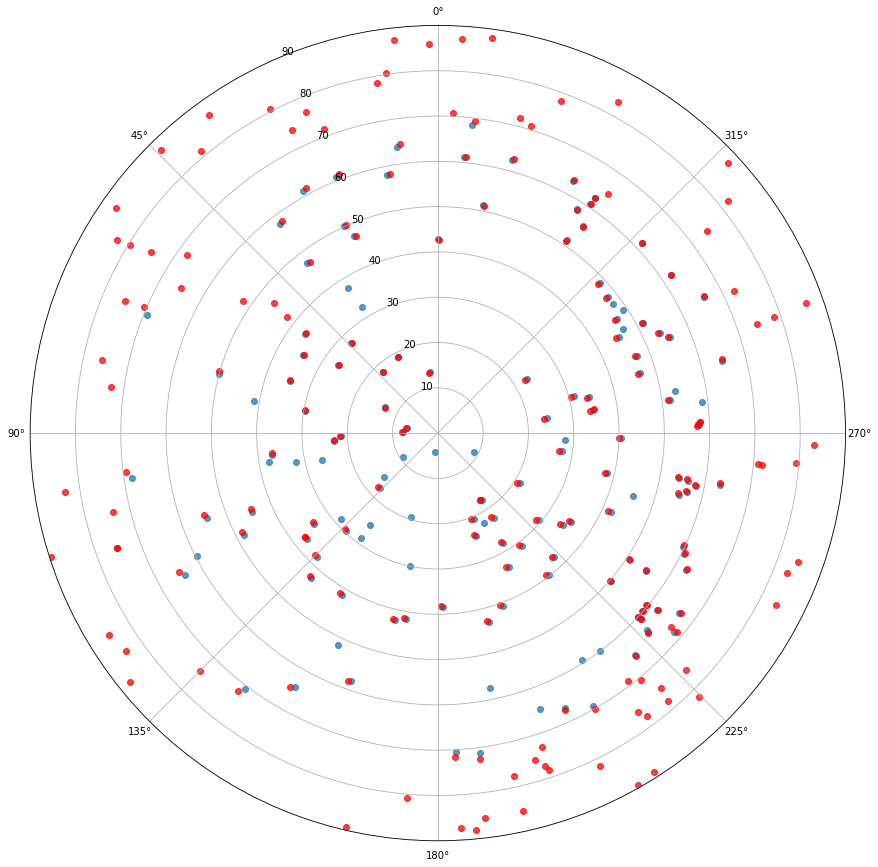

In [46]:
theta = []
azimuth = []
compmax = 200
for pixel in sources:
    alt, az = sensor2horizontal(pixel[0], pixel[1], gray.shape[0]//2+8, gray.shape[1]//2+15, math.pi/2+1.1*math.pi/180, f=1.52, dp=2.4, projection='equidistant', Z=-2.2)
    theta.append(90-alt*180/math.pi)
    azimuth.append(az)
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
c = ax.scatter(azimuth, theta, cmap='hsv', alpha=0.75)
d = ax.scatter(azimuth_comp[:compmax], theta_comp[:compmax], color='r', cmap='hsv', alpha=0.75)

ax.set_theta_zero_location('N')
ax.set_rmax(90)

plt.show()

In [47]:
icp = cv2.ppf_match_3d_ICP(100)

In [48]:
starcloud=np.transpose(np.array([azimuth_comp,theta_comp,[row[2] for row in starpos],[0 for row in starpos],[0 for row in starpos],[0 for row in starpos]]))
_, starcloud = cv2.ppf_match_3d.computeNormalsPC3d(starcloud[:200], 3, True,(0,0,1))
starcloud = starcloud.astype('float32')
objcloud=np.transpose(np.array([azimuth,theta,[row[2] for row in sources],[0 for row in sources],[0 for row in sources],[0 for row in sources]]))
_, objcloud = cv2.ppf_match_3d.computeNormalsPC3d(objcloud, 3, True,(0,0,1))
objcloud = objcloud.astype('float32')

In [49]:
retval, residual, pose = icp.registerModelToScene(objcloud, starcloud)

In [50]:
matchcloud = np.delete(cv2.ppf_match_3d.transformPCPose(objcloud, pose),[3,4,5], axis=1)

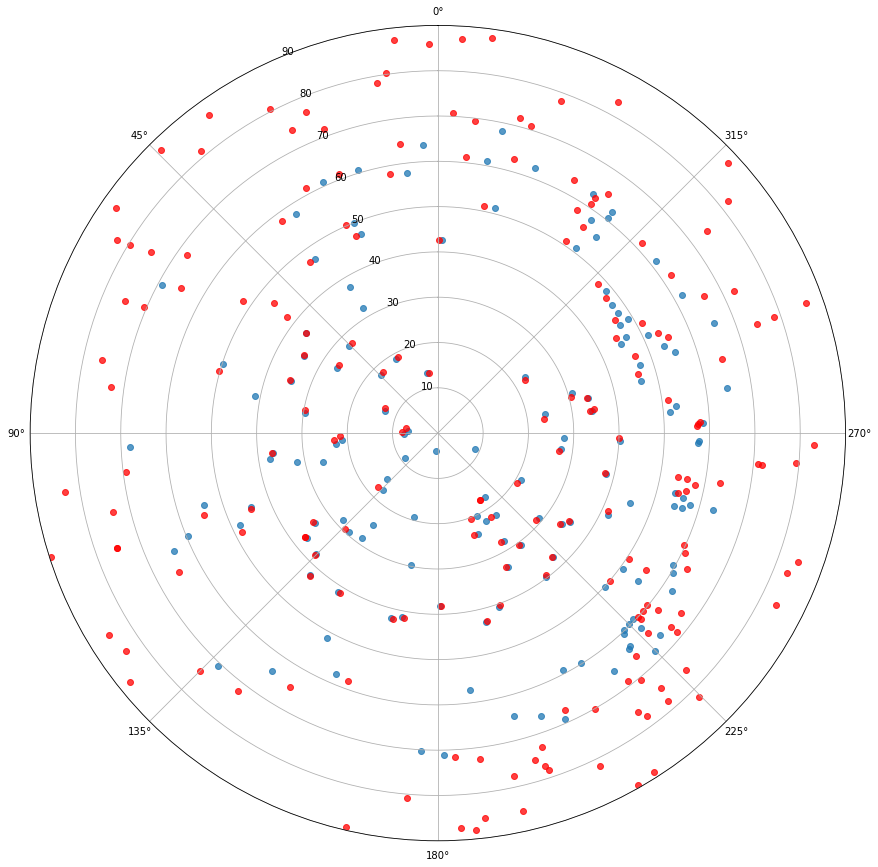

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
c = ax.scatter(list(matchcloud[:,0]), list(matchcloud[:,1]), cmap='hsv', alpha=0.75)
d = ax.scatter(azimuth_comp[:compmax], theta_comp[:compmax], color='r', cmap='hsv', alpha=0.75)

ax.set_theta_zero_location('N')
ax.set_rmax(90)

plt.show()

In [52]:
theta = []
azimuth = []
src = []
ref = []
compmax = 150
for pixel in sources:
    src.append([pixel[0] - (gray.shape[0]//2-100), pixel[1]-(gray.shape[1]//2+15), pixel[2]])
for star in starpos[:compmax]:
    x, y = horizontal2sensor(star[0], star[1], 0, 0, math.pi/2-8*math.pi/180, f=1.55, dp=2.4, projection='rectilinearshifted', Z=-2.2)
    ref.append([x,y,star[2]])

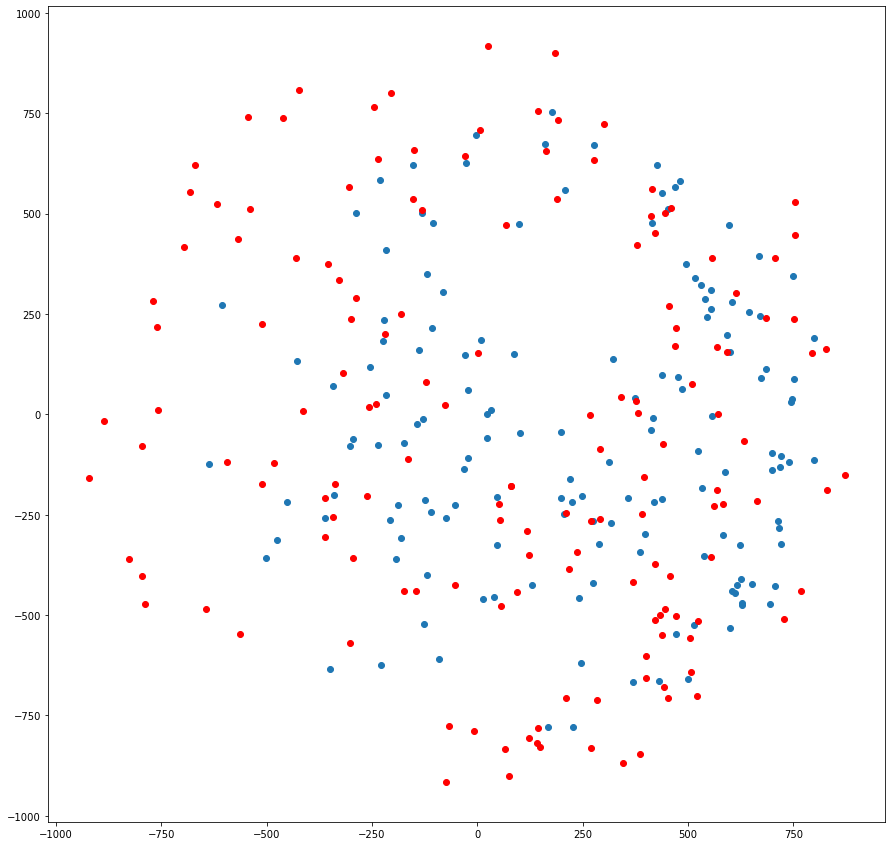

In [53]:
plt.scatter([row[0] for row in src], [row[1] for row in src])
plt.scatter([row[0] for row in ref], [row[1] for row in ref], color='r')
plt.show()

In [54]:
_, refcloud = cv2.ppf_match_3d.computeNormalsPC3d(np.pad(np.array(ref),((0,0),(0,3))), 3, True,(0,0,1))
refcloud = refcloud.astype('float32')
_, srccloud = cv2.ppf_match_3d.computeNormalsPC3d(np.pad(np.array(src),((0,0),(0,3))), 3, True,(0,0,1))
srccloud = objcloud.astype('float32')
retval, residual, pose = icp.registerModelToScene(refcloud, srccloud)
matchcloud = cv2.ppf_match_3d.transformPCPose(refcloud, pose)

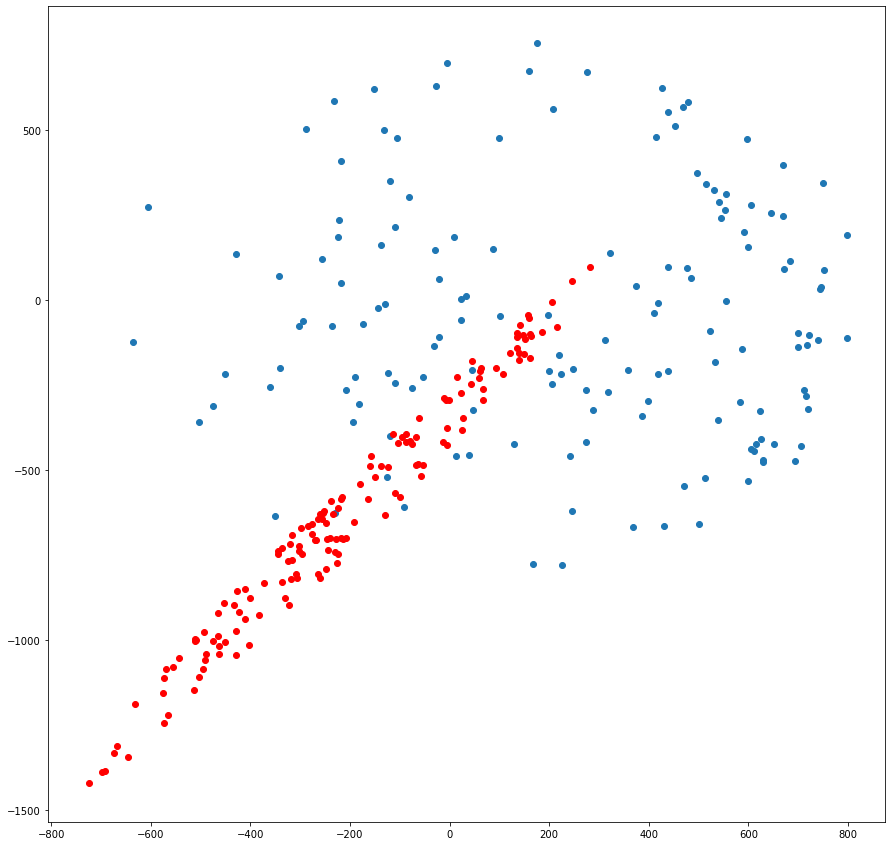

In [55]:
plt.scatter([row[0] for row in src], [row[1] for row in src])
plt.scatter([row[0] for row in matchcloud], [row[1] for row in matchcloud], color='r')
plt.show()

In [56]:
image = np.flip(cv2.imread('../tests/startrails20200102.png', -1),0)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype('single')
mask = np.zeros(gray.shape)
cv2.circle(mask, tuple([z // 2 for z in gray.shape]), int(0.9*(gray.shape[0] / 2)), 1., -1)
_ = np.multiply(gray, mask, out=gray)

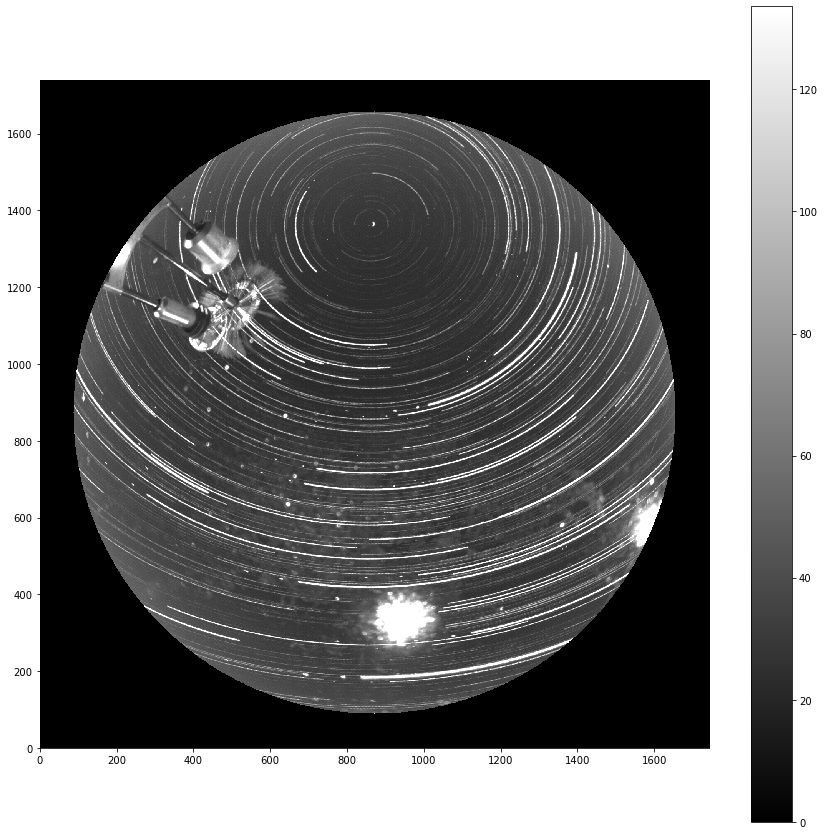

In [57]:
# show the image
m, s = np.mean(gray), 3*np.std(gray)
plt.imshow(gray, interpolation='nearest', cmap='gray', vmin=max(m-s,0), vmax=m+s, origin='lower')
plt.colorbar();

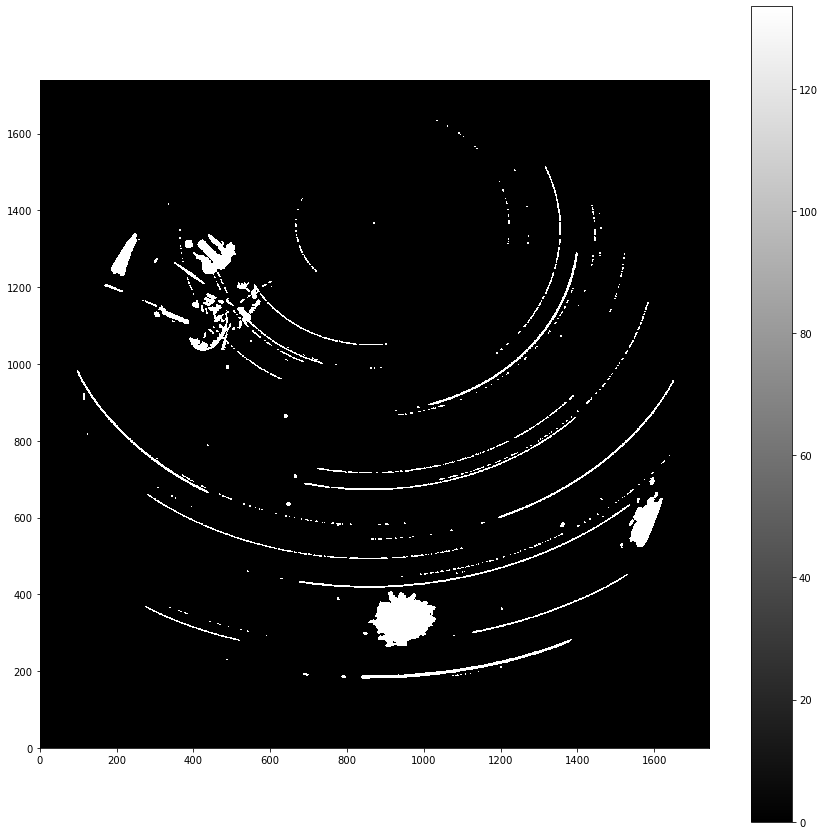

In [58]:
ret, thresh = cv2.threshold(gray, 80, 255, 0)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4)))
# show the image
m, s = np.mean(thresh), 3*np.std(thresh)
plt.imshow(thresh, interpolation='nearest', cmap='gray', vmin=max(m-s,0), vmax=m+s, origin='lower')
plt.colorbar();

In [59]:
contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(thresh), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

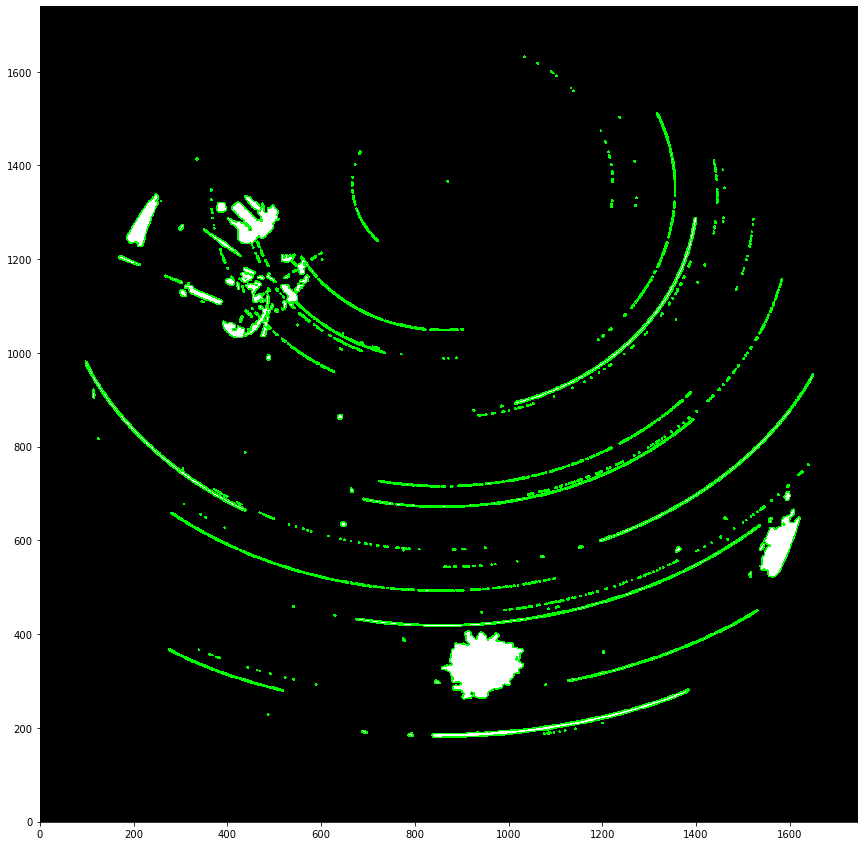

In [60]:
image = cv2.cvtColor(cv2.convertScaleAbs(thresh), cv2.COLOR_GRAY2BGR)
cv2.drawContours(image, contours, -1, (0,255,0), 2)
# show the image
plt.figure(figsize = (15,15))
plt.imshow(image, cmap='gray', origin='lower')

Routine for modelling startrails with specified declination and local sidereal time range

In [61]:
def equatorial2trail(alpha, delta, xc=0, yc=0, ts=0, te=24, num=100, phiN=90, f=1.55, dp=2.4, lat=46.973141, k=0, **kwargs):
    """
    returns two lists of x,y pixel coordinates of a star trail of the star with equatorial coordinates alpha and delta starting
    at the local star time ts and ending at the local star time te (both in hours) with a nr of steps of num. 
    The latitude of the observer is given in lat. The sensor and optics properties are the pixel size in um 
    specified in dp and the focal length (in mm) of the lens is specified in f. The projection is specified by the
    k parameter. If k>0 the z-shift may be given in the optional parameter Z (equal to 0.0mm if not specified). 
    The parameters xc and yc are specifying the pixel position of the
    zenith point on the sensor plane and phiN is the angle of the North direction on the sensor plane measured from
    the positive x-axis in mathematically positive direction.
    """
    if 'Z' not in kwargs:
        Z=0.0
    else:
        Z=kwargs['Z']

    # Calculate local start and end hour angle from rectascension and start and end local sidereal time
    Hs = (ts - alpha)*15*math.pi/180
    He = (te - alpha)*15*math.pi/180
    lat = lat*math.pi/180
    phiN = phiN*math.pi/180
    delta = delta*math.pi/180
    sindj = sin(delta)*sin(lat)
    x = []
    y = []
    for H in np.linspace(Hs, He, num):
        cosHdj = cos(H)*cos(delta)*cos(lat)
        if k<0:
            x.append(xc + 1000/dp*(f*(cos(lat)*cos(phiN)*sin(delta) + \
                                      cos(delta)*(-(cos(H)*cos(phiN)*sin(lat)) + sin(H)*sin(phiN)))* \
                         sin(k*acos(cosHdj + sindj)))/ \
                     (k*sqrt(1 - (cosHdj + sindj)**2)))
            y.append(yc + 1000/dp*(f*(cos(lat)*sin(delta)*sin(phiN) - \
                                      cos(delta)*(cos(phiN)*sin(H) + cos(H)*sin(lat)*sin(phiN)))* \
                         sin(k*acos(cosHdj + sindj)))/ \
                     (k*sqrt(1 - (cosHdj + sindj)**2)))
        elif k==0:
            x.append(xc + 1000/dp*(f*acos(cosHdj + sindj)*(cos(lat)*cos(phiN)*sin(delta) + cos(delta)* \
                                              (-(cos(H)*cos(phiN)*sin(lat)) + sin(H)*sin(phiN))))/ \
                      sqrt(1 - (cosHdj + sindj)**2))
            y.append(yc + 1000/dp*(f*acos(cosHdj + sindj)*(cos(lat)*sin(delta)*sin(phiN) - cos(delta)* \
                                              (cos(phiN)*sin(H) + cos(H)*sin(lat)*sin(phiN))))/ \
                      sqrt(1 - (cosHdj + sindj)**2))
        else:
            x.append(xc + 1000/dp*(f*(1 - Z)*(cos(lat)*cos(phiN)*sin(delta) + cos(delta)* \
                                 (-(cos(H)*cos(phiN)*sin(lat)) + sin(H)*sin(phiN))))/ \
                     (cosHdj + sindj - Z))
            y.append(yc + 1000/dp*(f*(1 - Z)*(cos(lat)*sin(delta)*sin(phiN) - cos(delta)* \
                                 (cos(phiN)*sin(H) + cos(H)*sin(lat)*sin(phiN))))/ \
                     (cosHdj + sindj - Z))
    return x,y

In [62]:
#Convert equatorial coordinates into horizontal ones and just take stars above horizon
star = ephem.FixedBody()
starbright = []
star._epoch = '1900'
for hd in yale_catalog['hd_numbers']:
    star._ra, star._dec = yale_catalog['stars'][hd][0] * math.pi / 180, yale_catalog['stars'][hd][1] * math.pi / 180
    pos = ephem.Equatorial(star._ra, star._dec, epoch='2020')
    starbright.append([pos.ra*180/math.pi/15, pos.dec*180/math.pi, yale_catalog['stars'][hd][2], yale_catalog['stars'][hd][-1]])

#Sort after magnitude
starbright.sort(key=lambda x: x[2])

In [63]:
[star for star in starbright if -9 < star[1] < -7 and star[2]<4.0]

[[5.242305555555555, -8.201666666666666, 0.12, 34085],
 [9.459777777777779, -8.65861111111111, 1.98, 81797],
 [0.32380555555555557, -8.823888888888888, 3.56, 1522],
 [1.400388888888889, -8.183333333333334, 3.6, 8512],
 [22.87691666666667, -7.579722222222222, 3.74, 216386],
 [18.58677777777778, -8.244166666666667, 3.85, 171443],
 [2.940472222222222, -8.898055555555553, 3.89, 18322]]

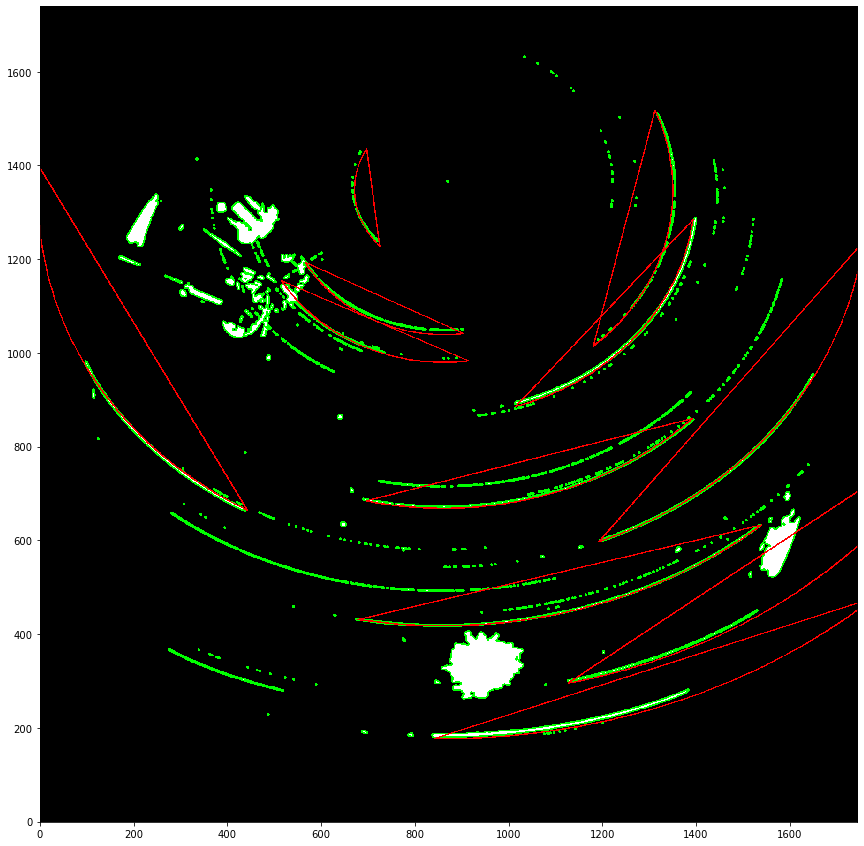

In [64]:
import ephem, math
position = ephem.Observer()
position.pressure = 0
position.lon, position.lat = str(15.398836), str(46.973066)
position.elevation = 350
# Star Trail Start Time of image was right after exposure, so half of the exposure time 20/2 = 10 s has been subtracted
# Time is in CET so we have to subtract 1hr as well
position.date = '2020/01/02 22:43:17'
lsts = position.sidereal_time()*180/math.pi/15
# Star Trail End Time of image was right after exposure, so half of the exposure time 20/2 = 10 s has been subtracted
position.date = '2020/01/03 03:41:24'
lste = position.sidereal_time()*180/math.pi/15
xc, yc = (869,877)
phiN = 90+0.8
k = 0
lat = 46.973141
f = 1.51
x, y = equatorial2trail(yale_catalog['stars'][131873][0]/15, yale_catalog['stars'][131873][1], xc=xc, yc=yc, ts=lsts, te=lste, num=100, phiN=phiN, f=f, dp=2.4, lat=lat, k=k)
trails = [np.column_stack((x, y)).astype('int32')]
x, y = equatorial2trail(yale_catalog['stars'][95689][0]/15, yale_catalog['stars'][95689][1], xc=xc, yc=yc, ts=lsts, te=lste, num=100, phiN=phiN, f=f, dp=2.4, lat=lat, k=k)
trails.append(np.column_stack((x, y)).astype('int32'))
x, y = equatorial2trail(yale_catalog['stars'][95418][0]/15, yale_catalog['stars'][95418][1], xc=xc, yc=yc, ts=lsts, te=lste, num=100, phiN=phiN, f=f, dp=2.4, lat=lat, k=k)
trails.append(np.column_stack((x, y)).astype('int32'))
x, y = equatorial2trail(yale_catalog['stars'][61421][0]/15, yale_catalog['stars'][61421][1], xc=xc, yc=yc, ts=lsts, te=lste, num=100, phiN=phiN, f=f, dp=2.4, lat=lat, k=k)
trails.append(np.column_stack((x, y)).astype('int32'))
x, y = equatorial2trail(yale_catalog['stars'][62509][0]/15, yale_catalog['stars'][62509][1], xc=xc, yc=yc, ts=lsts, te=lste, num=100, phiN=phiN, f=f, dp=2.4, lat=lat, k=k)
trails.append(np.column_stack((x, y)).astype('int32'))
x, y = equatorial2trail(yale_catalog['stars'][34029][0]/15, yale_catalog['stars'][34029][1], xc=xc, yc=yc, ts=lsts, te=lste, num=100, phiN=phiN, f=f, dp=2.4, lat=lat, k=k)
trails.append(np.column_stack((x, y)).astype('int32'))
x, y = equatorial2trail(yale_catalog['stars'][124897][0]/15, yale_catalog['stars'][124897][1], xc=xc, yc=yc, ts=lsts, te=lste, num=100, phiN=phiN, f=f, dp=2.4, lat=lat, k=k)
trails.append(np.column_stack((x, y)).astype('int32'))
x, y = equatorial2trail(yale_catalog['stars'][29139][0]/15, yale_catalog['stars'][29139][1], xc=xc, yc=yc, ts=lsts, te=lste, num=100, phiN=phiN, f=f, dp=2.4, lat=lat, k=k)
trails.append(np.column_stack((x, y)).astype('int32'))
x, y = equatorial2trail(yale_catalog['stars'][20902][0]/15, yale_catalog['stars'][20902][1], xc=xc, yc=yc, ts=lsts, te=lste, num=100, phiN=phiN, f=f, dp=2.4, lat=lat, k=k)
trails.append(np.column_stack((x, y)).astype('int32'))
x, y = equatorial2trail(yale_catalog['stars'][34085][0]/15, yale_catalog['stars'][34085][1], xc=xc, yc=yc, ts=lsts, te=lste, num=100, phiN=phiN, f=f, dp=2.4, lat=lat, k=k)
trails.append(np.column_stack((x, y)).astype('int32'))
x, y = equatorial2trail(yale_catalog['stars'][48915][0]/15, yale_catalog['stars'][48915][1], xc=xc, yc=yc, ts=lsts, te=lste, num=100, phiN=phiN, f=f, dp=2.4, lat=lat, k=k)
trails.append(np.column_stack((x, y)).astype('int32'))
result = image.copy()
cv2.drawContours(result, trails , -1, (255,0,0), 2)
# show the image
plt.figure(figsize = (15,15))
plt.imshow(result, cmap='gray', origin='lower')

In [65]:
import random as rng
rng.seed(12345)
# Find the rotated rectangles and ellipses for each contour
minRect = [None]*len(contours)
minEllipse = [None]*len(contours)
for i, c in enumerate(contours):
    if c.shape[0] > 300:
        minRect[i] = cv2.minAreaRect(c)
        minEllipse[i] = cv2.fitEllipse(c)
# Draw contours + rotated rects + ellipses
    
drawing = np.zeros((thresh.shape[0], thresh.shape[1], 3), dtype=np.uint8)
for i, c in enumerate(contours):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    # contour
    # ellipse
    if c.shape[0] > 300:
        cv2.drawContours(drawing, contours, i, color)
        cv2.ellipse(drawing, minEllipse[i], color, 2)
        # rotated rectangle
        box = cv2.boxPoints(minRect[i])
        box = np.intp(box) #np.intp: Integer used for indexing (same as C ssize_t; normally either int32 or int64)
        cv2.drawContours(drawing, [box], 0, color)

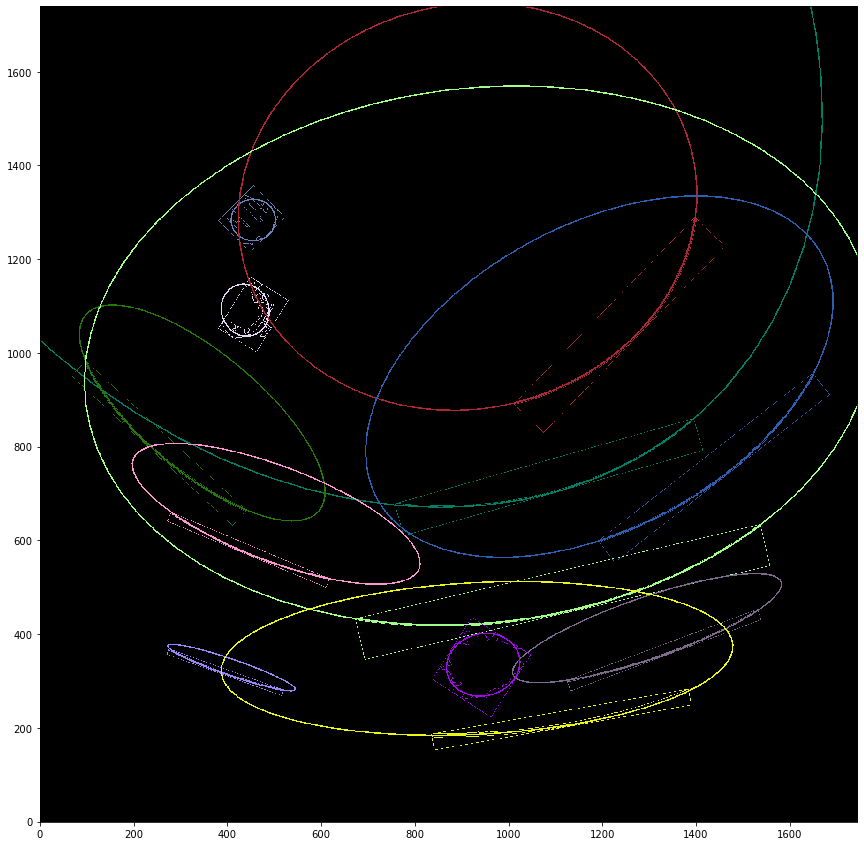

In [66]:
plt.imshow(drawing, cmap='gray', origin='lower')